In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import sys
sys.path.insert(0, '/pbabkin/main/mipt/nas-for-moe/code')
sys.path.insert(0, '/pbabkin/main/mipt/nas-for-moe/code/nas_moe')
import nas_moe.vae
import nas_moe.utils

SEED = 322
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
train_dataset = torchvision.datasets.CIFAR10(
    root='/pbabkin/main/mipt/nas-for-moe/code/data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified


In [3]:
split_valid = int(10000)
num_samples = len(train_dataset)
indices = list(range(num_samples))
np.random.seed(42)
np.random.shuffle(indices)
valid_subset = Subset(train_dataset, indices[split_valid:])
valid_labels = [label for im, label in valid_subset]

# Train VAE

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(
        brightness=0.1, 
        contrast=0.1, 
        saturation=0.1,
        hue=0.0  # опционально
    ),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(
    root='/pbabkin/main/mipt/nas-for-moe/code/data',
    train=True,
    download=True,
    transform=transform_train
)
val_dataset = datasets.CIFAR10(
    root='/pbabkin/main/mipt/nas-for-moe/code/data', 
    train=False,
    download=True, 
    transform=transform_val
)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = nas_moe.vae.VAE(latent_dim=128, channel_num=3)

model2 = nas_moe.vae.VAEv2(
    input_channels=3,
    input_size=32,
    filter_sizes=[32, 64, 128],
    latent_dim=64,
    kernel_size=3,
    stride=2,
    padding=1,
    is_variational=True 
)

trainer = nas_moe.vae.VAETrainer(model2, device, lr=2e-4, weight_decay=1e-5)
# trainer = nas_moe.vae.VAETrainer(model, device, lr=1e-4, weight_decay=1e-5)

In [6]:
if False:
    history = trainer.train(
        train_loader,
        val_loader,
        epochs=100,
        alpha=1.  # ← Как в TensorFlow версии!
    )
    trainer.plot_training_history()
    trainer.save_checkpoint('/pbabkin/main/mipt/nas-for-moe/vae_checkpoint_6.pth')
else:
    trainer.load_checkpoint('/pbabkin/main/mipt/nas-for-moe/vae_checkpoint_anton_1.pth')

/pbabkin/main/mipt/nas-for-moe/code/nas_moe/vae.py:521: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)


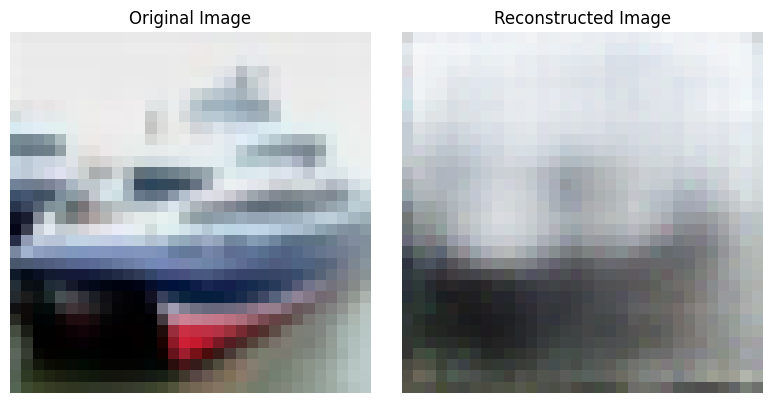

In [7]:
# Взять первое изображение из датасета
original_img = val_dataset[1][0]  # shape: (3, 32, 32)

# Восстановить изображение
reconstructed = trainer.reconstruct_image(original_img)  # shape: (1, 3, 32, 32)

# Вывести оригинальное и восстановленное изображение
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Оригинальное изображение
axes[0].imshow(original_img.permute(1, 2, 0).numpy())
axes[0].set_title('Original Image')
axes[0].axis('off')

# Восстановленное изображение
reconstructed_img = reconstructed[0].permute(1, 2, 0).numpy()
axes[1].imshow(reconstructed_img)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

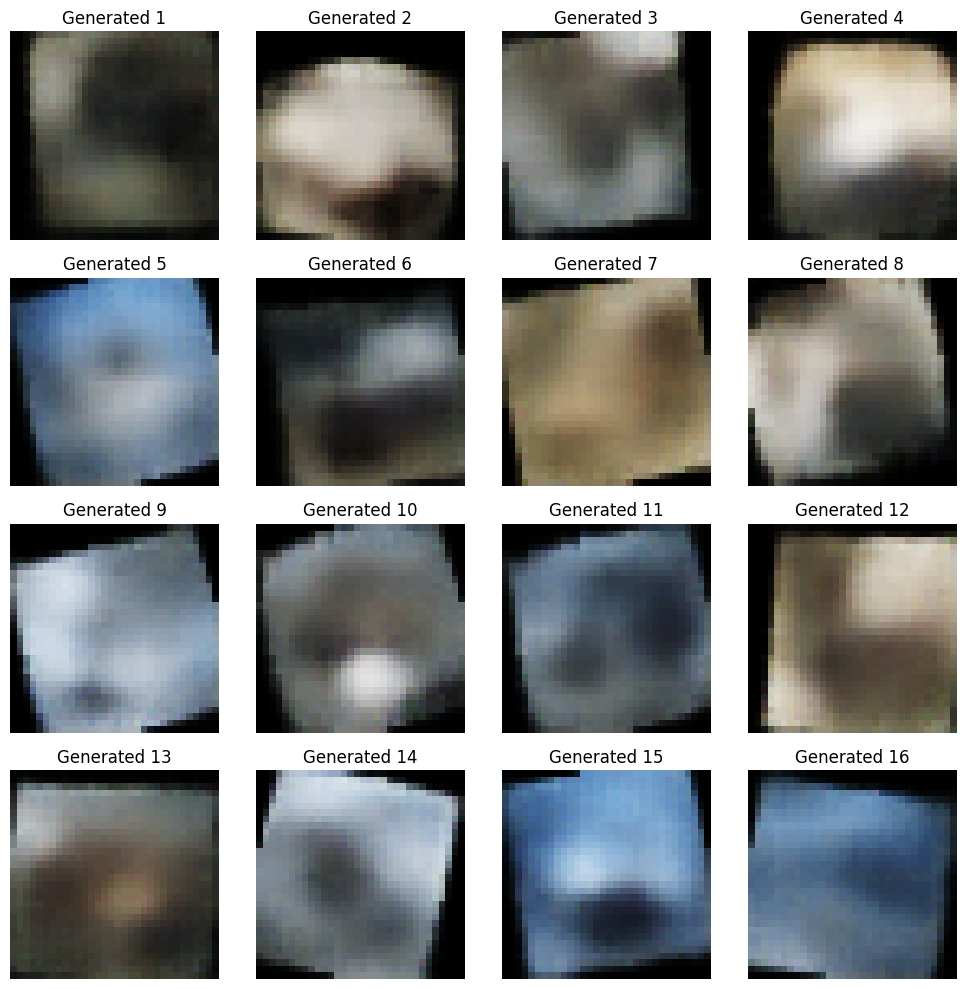

In [8]:
# Сгенерировать 16 новых изображений
generated_images = trainer.generate(num_samples=16)  # shape: (16, 3, 32, 32)

# Вывести сгенерированные изображения
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    img = generated_images[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f'Generated {idx+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Кластеризация

In [10]:
# Подготовка данных
images = []
labels = []

for img, label in valid_subset:
    z = trainer.encode_image(img)  # Получаем латентный вектор (тензор)
    images.append(z.cpu().numpy())  # Переводим в numpy

    # img_array = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    # img_flat = img_array.flatten()
    # images.append(img_flat)

    labels.append(label)

# Конвертируем в numpy array
X = np.array(images)
y = np.array(labels)
print(f"Форма данных: {X.shape}")

# 3072 - просто

Форма данных: (40000, 64)


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
K = 2
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10, verbose=0)
kmeans.fit(X_scaled)

# Получаем предсказанные кластеры
clusters = kmeans.labels_

print(f"Кластеризация завершена!")
print(f"Количество уникальных кластеров: {len(np.unique(clusters))}")
print(f"Inertia (сумма квадратов расстояний): {kmeans.inertia_:.2f}")

Кластеризация завершена!
Количество уникальных кластеров: 2
Inertia (сумма квадратов расстояний): 2377480.50


In [13]:
unique, counts = np.unique(clusters, return_counts=True)
print("\nРаспределение по кластерам:")
for cluster_id, count in zip(unique, counts):
    print(f"  Кластер {cluster_id}: {count} образцов")


Распределение по кластерам:
  Кластер 0: 17168 образцов
  Кластер 1: 22832 образцов


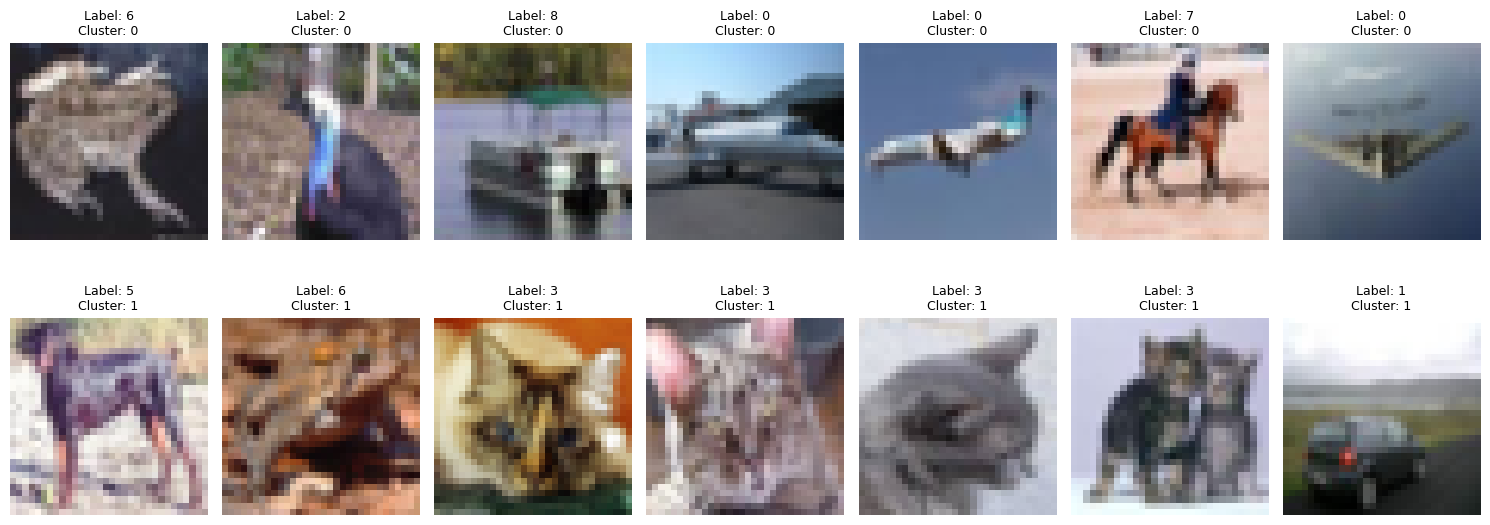

In [14]:
# Группируем индексы по кластерам
from collections import defaultdict

cluster_indices = defaultdict(list)
for idx in range(len(clusters)):
    cluster_indices[clusters[idx]].append(idx)

# Количество изображений на кластер
imgs_per_cluster = 7
num_clusters = len(cluster_indices)

# Создаем фигуру с количеством рядов = количество кластеров
fig, axes = plt.subplots(num_clusters, imgs_per_cluster, figsize=(15, 3 * num_clusters))

# Если только один кластер, axes будет 1D, поэтому преобразуем в 2D
if num_clusters == 1:
    axes = axes.reshape(1, -1)

# Заполняем каждый ряд изображениями из одного кластера
for cluster_id in sorted(cluster_indices.keys()):
    indices = cluster_indices[cluster_id]
    
    for col_idx in range(imgs_per_cluster):
        ax = axes[cluster_id, col_idx]
        
        if col_idx < len(indices):
            # Получаем изображение и лейбл
            img, label = valid_subset[indices[col_idx]]
            
            if isinstance(img, torch.Tensor):
                img_array = img.permute(1, 2, 0).numpy()
            else:
                img_array = img
            
            ax.imshow(img_array)
            ax.set_title(f'Label: {label}\nCluster: {cluster_id}', fontsize=9)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

# Fake clusters

In [15]:
# n = len(clusters)  # длина массива
# fake_clusters = np.random.randint(0, 10, size=n)
# clusters = fake_clusters
# clusters = valid_labels

# Считывание архитектур

In [16]:
import os
import json
from pathlib import Path

In [2]:
folder_path = Path('/pbabkin/main/mipt/nas-for-moe/code/data/CIFAR10_acc/trained_models_archs_1')
# folder_path = Path('/pbabkin/main/mipt/nas-for-moe/code/data/CIFAR10_div/CIFAR10_div/architectures')
# folder_path = Path('./data/CIFAR10_div/CIFAR10_div/architectures')
json_paths = [Path(x) for x in os.listdir(folder_path)]

In [3]:
valid_predictions_list = []
valid_acc_list = []
architecture_list = []
for json_path in json_paths:
    with open(folder_path / json_path, 'r') as file:
        data = json.load(file)

    valid_predictions_list += [data['valid_predictions']]
    valid_acc_list += [data['valid_accuracy']]
    architecture_list.append(data['architecture'])
        
    file_path = Path("data.json")

In [9]:
min(valid_acc_list)
# max(valid_acc_list)

0.72595

In [19]:
print(len(valid_acc_list))
print(np.array(valid_acc_list).mean(), np.array(valid_acc_list).std())

1000
0.7534777 0.0071545950416498074


# Подсчет точности по кластерам

In [20]:
a = np.array(valid_labels)
b = np.array(valid_predictions_list[0])

In [21]:
print('Рассчитанная точность по ответам', (a == b).sum() / len(a))
print('Точность из json = ', valid_acc_list[0])

Рассчитанная точность по ответам 0.75815
Точность из json =  0.75815


In [22]:
cluster_acc_std_list = []
for i in range(len(valid_predictions_list)):
    preds = np.array(valid_predictions_list[i])
    is_correct = (preds == valid_labels)
    
    unique, counts = np.unique(clusters, return_counts=True)
    clusters_acc_list = []
    for cluster_id, count in zip(unique, counts):
        cluster_indexes = (clusters == cluster_id)
        cluster_results = is_correct[cluster_indexes]
        assert cluster_results.size == count
        cluster_acc = cluster_results.sum() / cluster_results.size
        clusters_acc_list.append(cluster_acc)
        # print(cluster_id, cluster_acc)
    cluster_acc_std_list.append(np.array(clusters_acc_list).std())

0.00998739518642921


/tmp/ipykernel_127/174553937.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


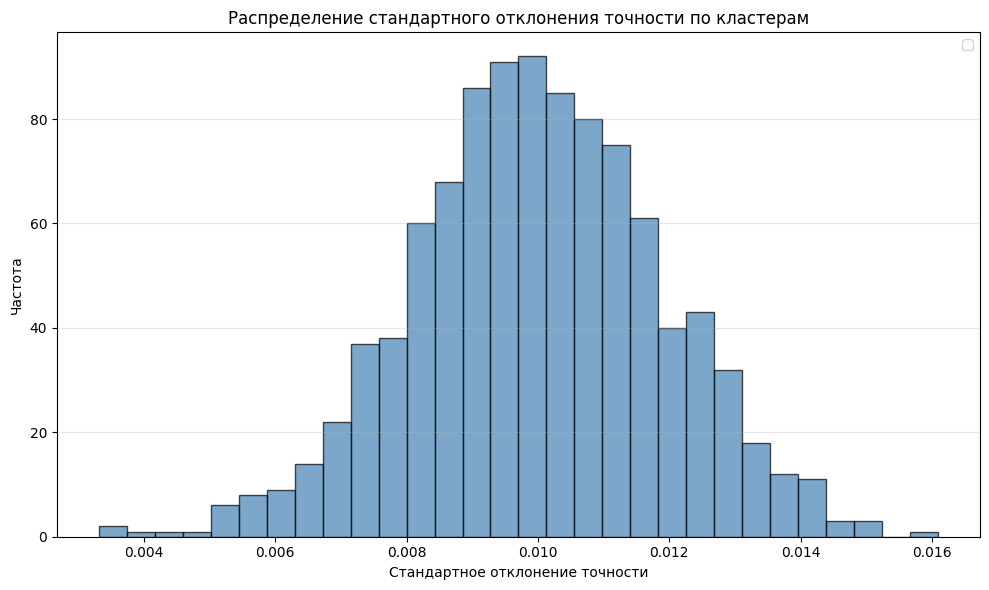

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(cluster_acc_std_list, bins=30, color='steelblue', edgecolor='black', alpha=0.7)

plt.xlabel('Стандартное отклонение точности')
plt.ylabel('Частота')
plt.title('Распределение стандартного отклонения точности по кластерам')
plt.grid(axis='y', alpha=0.3)

# Добавить статистику на график
mean_std = np.mean(cluster_acc_std_list)
median_std = np.median(cluster_acc_std_list)

print(mean_std)



plt.legend()
plt.tight_layout()
plt.show()

2 кластера => разброс -- 0.01

разбиение по label => разброс -- 0.085

vae => 0.024

# Plot graph

In [28]:
from tqdm import tqdm

In [29]:
Ks = range(2, 100)
mean_std_list = []

for K in tqdm(Ks):
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10, verbose=0)
    kmeans.fit(X_scaled)

    # Получаем предсказанные кластеры
    clusters = kmeans.labels_


    cluster_acc_std_list = []
    for i in range(len(valid_predictions_list)):
        preds = np.array(valid_predictions_list[i])
        is_correct = (preds == valid_labels)
        
        unique, counts = np.unique(clusters, return_counts=True)
        clusters_acc_list = []
        for cluster_id, count in zip(unique, counts):
            cluster_indexes = (clusters == cluster_id)
            cluster_results = is_correct[cluster_indexes]
            assert cluster_results.size == count
            cluster_acc = cluster_results.sum() / cluster_results.size
            clusters_acc_list.append(cluster_acc)
            # print(cluster_id, cluster_acc)
        cluster_acc_std_list.append(np.array(clusters_acc_list).std())

    mean_std = np.mean(cluster_acc_std_list)

    # print(mean_std)
    mean_std_list.append(mean_std)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [10:07<00:00,  6.20s/it]


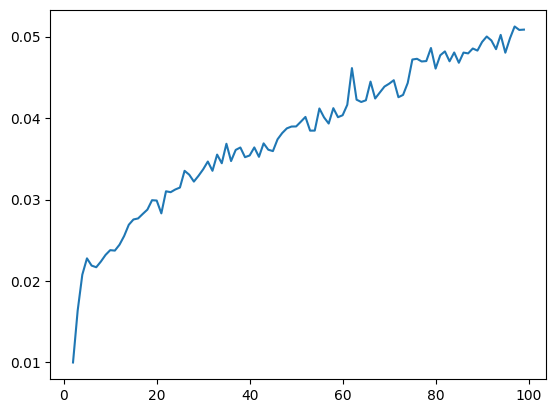

In [30]:
plt.plot(Ks, mean_std_list)